# Solving orbital equations with different algorithms

This notebook was adapted from `Orbit_games.ipynb`.



We consider energy plots and orbital solutions in polar coordinates for the general potential energy

$\begin{align}
   U(r) = k r^n
\end{align}$

for different ODE solution algorithms.  The `solve_ivp` function can itself be specified to use different solution methods (with the `method` keyword).  Here we will set it by default to use 'RK23', which is a variant on the Runge-Kutta second-order algorithm.  Second-order in this context means that the accuracy of a calculation will improve by a factor of $10^2 = 100$ if $\Delta t$ is reduced by a factor of ten. 

We will compare it with the crudest algorithm, Euler's method, which is first order, and a second-order algorithm called Leapfrog, which is designed to be precisely <em>time-reversal invariant</em>.  This property guarantees conservation of energy, which is not true of the other algorithms we will consider.

To solve the differential equations for orbits, we have defined the $\mathbf{y}$ 
and $d\mathbf{y}/dt$ vectors as

$\begin{align}
  \mathbf{y} = \left(\begin{array}{c} r(t) \\ \dot r(t) \\ \phi(t)  \end{array} \right) 
  \qquad
  \frac{d\mathbf{y}}{dt} 
       = \left(\begin{array}{c} \dot r(t) \\ \ddot r(t) \\ \dot\phi(t) \end{array} \right) 
       = \left(\begin{array}{c} \dot r(t) \\ 
                                 -\frac{1}{\mu}\frac{dU_{\rm eff}(r)}{dr} \\ 
                                 \frac{l}{\mu r^2} \end{array} \right) 
\end{align}$

where we have substituted the differential equations for $\ddot r$ and $\dot\phi$.

Then Euler's method can be written as a simple prescription to obtain $\mathbf{y}_{i+1}$ 
from $\mathbf{y}_i$, where the subscripts label the elements of the `t_pts` array: 
$\mathbf{y}_{i+1} = \mathbf{y}_i + \left(d\mathbf{y}/dt\right)_i \Delta t$, or, by components:

$\begin{align}
   r_{i+1} &= r_i + \frac{d\mathbf{y}_i[0]}{dt}  \Delta t  \\
   \dot r_{i+1} &= \dot r_{i} + \frac{d\mathbf{y}_i[1]}{dt}  \Delta t \\
   \phi_{i+1} &= \phi_i + \frac{d\mathbf{y}_i[2]}{dt} \Delta t
\end{align}$

**Look at the** `solve_ode_Euler` **method below and verify the algorithm is correctly implemented.** 

The leapfrog method does better by evaluating $\dot r$ at a halfway time step before and after the $r$ evaluation, 
which is both more accurate and incorporates time reversal: 

$\begin{align}
   \dot r_{i+1/2} &= \dot r_{i} + \frac{d\mathbf{y}_i[1]}{dt}  \Delta t/2 \\
   r_{i+1} &= r_i +  \dot r_{i+1/2}  \Delta t  \\
   \dot r_{i+1} &= \dot r_{i+1/2} + \frac{d\mathbf{y}_{i+1}[1]}{dt}  \Delta t/2 \\
   \phi_{i+1} &= \phi_i + \frac{d\mathbf{y}_i[2]}{dt} \Delta t
\end{align}$

**Look at the** `solve_ode_Leapfrog` **method below and verify the algorithm is correctly implemented.** 

A third method is the second-order Runge-Kutta algorithm, which we invoke from `solve_ivp` as `RK23`. 
It does not use a fixed time-step as in our "homemade" implementations, so there is not a direct 
comparison, but we can still check if it conserves energy.

**Run the notebook.  You are to turn in and comment on the "Change in energy with time" plot at the end.  
Where do you see energy conserved or not conserved?  Show that Euler is first order and leapfrog is second 
order by changing $\Delta t$; describe what you did and what you found.**

**Try another potential to see if you get the same general conclusions.**

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [26]:
# Change the common font size
font_size = 14
plt.rcParams.update({'font.size': font_size})

In [69]:
class Oscillator():
    """
    Oscillator class is a general class for solving the differential equation for 
    the motion of a given oscillator
     
    Parameters
    ----------
    omega : The frequency of the osillator

    Methods
    -------
    solve_ode
        uses solve_ivp to solve the differential equation dy_dt passed to it.
    """
    def __init__(self, G=1., m1=1., m2=1.
                ):
        self.G = G
        self.m1 = m1
        self.m2 = m2
        
    def dy_dt(self, t, z):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi/dt d^2phi/dt^2]
        
        Parameters
        ----------
        z : float
            A 2-component vector with z[0] = x1(t) and z[1] = dx1(t)/dt
                                      z[2] = x2(t) and z[3] = dx2(t)/dt
                                      z[4] = y1(t) and z[5] = dy1(t)/dt
                                      z[6] = y2(t) and z[7] = dy2(t)/dt

        t : float
            time 
            
        Returns
        -------
        
        """
        r = np.sqrt((z[0] - z[2])**2 + (z[4] - z[6])**2)
        x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot = z
        
        
        return [x1_dot, self.m2 * self.G * (x2 - x1) / r**3,\
                x2_dot, self.m1 * self.G * (x1 - x2) / r**3,\
                y1_dot, self.m2 * self.G * (y2 - y1) / r**3,\
                y2_dot, self.m1 * self.G * (y1 - y2) / r**3]
    
    def solve_ode(self, t_pts, z_0,
                  method='RK23',
                  abserr=1.0e-8, relerr=1.0e-8):
        """
        Solve the ODE given initial conditions.
        Use solve_ivp with the option of specifying the method.
        Specify smaller abserr and relerr to get more precision.
        """
        
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             z_0, t_eval=t_pts, method=method, 
                             atol=abserr, rtol=relerr)
        
        x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot = solution.y
        
        return x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot

In [70]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [71]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

# Pick a potential

In [72]:
G=1. 
m1=1.
m2=100.

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

p1 = Oscillator(G=G, m1=m1, m2=m2)

In [73]:
x1_0 = 1.
x2_0 = (-m1/m2)*x1_0
x1_dot_0 = 2.
x2_dot_0 = (-m1/m2)*x1_dot_0
y1_0 = 0.
y2_0 = (-m1/m2)*y1_0
y1_dot_0 = 2.
y2_dot_0 = (-m1/m2)*y1_dot_0

z_0 = [x1_0, x2_0, x1_dot_0, x2_dot_0, y1_0, y2_0, y1_dot_0, y2_dot_0]

x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot = p1.solve_ode(t_pts, z_0)

In [74]:
print(x1)
print(y1)

[1.         1.00034731 1.00159017 1.0037312  1.00677467 1.01072655
 1.01559457 1.0213883  1.02811926 1.03580102 1.04444941 1.05408264
 1.06472159 1.07639002 1.08911497 1.10292707 1.11786111 1.13395653
 1.15125821 1.16981727 1.18969226 1.21095044 1.23366961 1.25794036
 1.28386904 1.31158179 1.34122998 1.3729979  1.40711385 1.44386667
 1.48363167 1.52691326 1.57442038 1.62721251 1.68702218 1.75712869
 1.84583379]
[0.00000000e+00 8.94621173e-04 3.58034350e-03 8.06240160e-03
 1.43493398e-02 2.24530988e-02 3.23891385e-02 4.41766000e-02
 5.78385115e-02 7.34020427e-02 9.08988157e-02 1.10365281e-01
 1.31843171e-01 1.55380043e-01 1.81029933e-01 2.08854150e-01
 2.38922223e-01 2.71313069e-01 3.06116413e-01 3.43434546e-01
 3.83384515e-01 4.26100879e-01 4.71739227e-01 5.20480723e-01
 5.72538083e-01 6.28163575e-01 6.87659955e-01 7.51395809e-01
 8.19827708e-01 8.93533347e-01 9.73263331e-01 1.06002651e+00
 1.15524076e+00 1.26102502e+00 1.38084437e+00 1.52125738e+00
 1.69886758e+00]


(<AxesSubplot:title={'center':'$x(t)$'}>,
 <matplotlib.lines.Line2D at 0x7fc30e8d0460>)

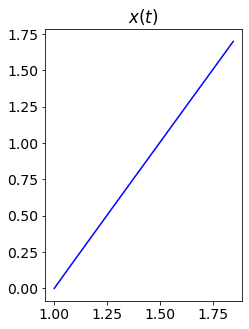

In [75]:
fig = plt.figure(figsize=(12,5))
ax_a = fig.add_subplot(1,3,1)

start, stop = start_stop_indices(t_pts, t_start, t_end)    
#plot_y_vs_x(t_pts[start : len(x1)], x1[start : len(x1)],  
#            color='blue',
#            label=None, 
#            title=r'$x(t)$', 
#            ax=ax_a) 
plot_y_vs_x(x1[start : len(x1)], y1[start : len(x1)],  
            color='blue',
            label=None, 
            title=r'$x(t)$', 
            ax=ax_a) 

## Plot orbit and check energy conservation

In [ ]:
# Plotting time 
t_start = 0.
t_end = 10.
delta_t = 0.0001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

# Initial conditions
r_0 = 1.  #  1.
r_dot_0 = 0.
phi_0 = 0.0
r_pts, r_dot_pts, phi_pts = o1.solve_ode(t_pts, r_0, r_dot_0, phi_0)
r_pts_Euler, r_dot_pts_Euler, phi_pts_Euler \
                              = o1.solve_ode_Euler(t_pts, r_0, r_dot_0, phi_0)
r_pts_LF, r_dot_pts_LF, phi_pts_LF \
                           = o1.solve_ode_Leapfrog(t_pts, r_0, r_dot_0, phi_0)

c = o1.ang_mom**2 / (np.abs(o1.k) * o1.mu)
epsilon = c / r_0 - 1.
energy_0 = o1.mu/2. * r_dot_0**2 + o1.Ueff(r_0)
print(f'energy = {energy_0:.2f}')
print(f'eccentricity = {epsilon:.2f}')

In [ ]:
fig_4 = plt.figure(figsize=(8,8))

overall_title = 'Orbit:  ' + \
                rf' $n = {o1.n},$' + \
                rf' $k = {o1.k:.1f},$' + \
                rf' $l = {o1.ang_mom:.1f},$' + \
                rf' $r_0 = {r_0:.1f},$' + \
                rf' $\dot r_0 = {r_dot_0:.1f},$' + \
                rf' $\phi_0 = {phi_0:.1f}$' + \
                '\n'     # \n means a new line (adds some space here)
fig_4.suptitle(overall_title, va='baseline')

ax_4a = fig_4.add_subplot(2,2,1)
ax_4a.plot(t_pts, r_pts, color='black', label='RK23')
ax_4a.plot(t_pts, r_pts_Euler, color='blue', label='Euler')
ax_4a.plot(t_pts, r_pts_LF, color='red', label='Leapfrog')
ax_4a.set_xlabel(r'$t$')
ax_4a.set_ylabel(r'$r$')
ax_4a.set_title('Time dependence of radius')
ax_4a.legend()

ax_4b = fig_4.add_subplot(2,2,2)
ax_4b.plot(t_pts, phi_pts/(2.*np.pi), color='black', label='RK23')
ax_4b.plot(t_pts, phi_pts_Euler/(2.*np.pi), color='blue', label='Euler')
ax_4b.plot(t_pts, phi_pts_LF/(2.*np.pi), color='red', label='Leapfrog')
ax_4b.set_xlabel(r'$t$')
ax_4b.set_ylabel(r'$\phi/2\pi$')
ax_4b.set_title(r'Time dependence of $\phi$')
ax_4b.legend()

ax_4c = fig_4.add_subplot(2,2,3)
ax_4c.plot(r_pts*np.cos(phi_pts), r_pts*np.sin(phi_pts), 
           color='black', label='RK23')
ax_4c.plot(r_pts_Euler*np.cos(phi_pts_Euler), 
           r_pts_Euler*np.sin(phi_pts_Euler), 
           color='blue', label='Euler')
ax_4c.plot(r_pts_LF*np.cos(phi_pts_LF), 
           r_pts_LF*np.sin(phi_pts_LF), 
           color='red', label='Leapfrog')
ax_4c.set_xlabel(r'$x$')
ax_4c.set_ylabel(r'$y$')
ax_4c.set_aspect('equal')
ax_4c.set_title('Cartesian plot')
ax_4c.legend()

ax_4d = fig_4.add_subplot(2,2,4, polar=True)
ax_4d.plot(phi_pts, r_pts, color='black', label='RK23')
ax_4d.plot(phi_pts_Euler, r_pts_Euler, color='blue', label='Euler')
ax_4d.plot(phi_pts_LF, r_pts_LF, color='red', label='Leapfrog')
ax_4d.set_title('Polar plot', pad=20.)
ax_4d.legend()


fig_4.tight_layout()
fig_4.savefig('Leapfrog_orbit_1.png', dpi=200, bbox_inches='tight')



In [ ]:
E_tot_pts = o1.energy(t_pts, r_pts, r_dot_pts)
E_tot_0 = E_tot_pts[0]
E_tot_rel_pts = np.abs((E_tot_pts - E_tot_0)/E_tot_0)

E_tot_pts_Euler = o1.energy(t_pts, r_pts_Euler, r_dot_pts_Euler)
E_tot_0_Euler = E_tot_pts_Euler[0]
E_tot_rel_pts_Euler = np.abs((E_tot_pts_Euler - E_tot_0_Euler)/E_tot_0_Euler)

E_tot_pts_LF = o1.energy(t_pts, r_pts_LF, r_dot_pts_LF)
E_tot_0_LF = E_tot_pts_LF[0]
E_tot_rel_pts_LF = np.abs((E_tot_pts_LF - E_tot_0_LF)/E_tot_0_LF)


In [ ]:
fig_5 = plt.figure(figsize=(6,6))

overall_title = 'Orbit:  ' + \
                rf' $n = {o1.n},$' + \
                rf' $k = {o1.k:.1f},$' + \
                rf' $l = {o1.ang_mom:.1f},$' + \
                rf' $r_0 = {r_0:.1f},$' + \
                rf' $\dot r_0 = {r_dot_0:.1f},$' + \
                rf' $\phi_0 = {phi_0:.1f}$' + \
                '\n'     # \n means a new line (adds some space here)
fig_5.suptitle(overall_title, va='baseline')

ax_5a = fig_5.add_subplot(1,1,1)
#ax_5a.semilogy(t_pts, np.abs(E_tot_pts), color='black', label=r'$E(t)$')
ax_5a.semilogy(t_pts, E_tot_rel_pts, 
               color='green', label=r'$\Delta E(t)$ RK23')
ax_5a.semilogy(t_pts, E_tot_rel_pts_Euler, 
               color='blue', label=r'$\Delta E(t)$ Euler')
ax_5a.semilogy(t_pts, E_tot_rel_pts_LF, 
               color='red', label=r'$\Delta E(t)$ Leapfrog')
ax_5a.set_ylim(1.e-10, 1.e-2)    # (1.e-12, 5)
ax_5a.set_xlabel(r'$t$')
ax_5a.set_ylabel(r'Energy')
ax_5a.set_title('Change in energy with time')
ax_5a.legend(bbox_to_anchor=(0.5, 0.5))

fig_5.tight_layout()
fig_5.savefig('Leapfrog_energy_test2_t_0.0001.png', dpi=200, bbox_inches='tight')
